**Практическая работа №2**



Выполнил студент группы ББМО-02-23 Курченко Иван.



---



# *Шаг 1: Импорт библиотек и загрузка модели*


In [ ]:
from tensorflow.keras import layers, models

# Создание простой модели LeNet для MNIST
def create_lenet_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

# Создание и компиляция модели
model = create_lenet_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Преобразование данных для обучения
train_images = test_images.reshape((-1, 28, 28, 1))  # Изменение формы для Conv2D
test_images = test_images.reshape((-1, 28, 28, 1))

# Обучение модели на MNIST данных
model.fit(train_images, test_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels))

# Сохранение обученной модели
model.save('mnist_model.h5')

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.7065 - loss: 1.0455 - val_accuracy: 0.9118 - val_loss: 0.2716
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9508 - loss: 0.1613 - val_accuracy: 0.9791 - val_loss: 0.0749
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9786 - loss: 0.0711 - val_accuracy: 0.9862 - val_loss: 0.0478
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.9864 - loss: 0.0456 - val_accuracy: 0.9863 - val_loss: 0.0446
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9886 - loss: 0.0389 - val_accuracy: 0.9882 - val_loss: 0.0345


# *Шаг 2: Реализация FGSM-атаки*

In [ ]:
# Функция для реализации FGSM-атаки
def fgsm_attack(image, epsilon, gradient):
    # Применение знака градиента к изображению для создания возмущений
    perturbed_image = image + epsilon * np.sign(gradient)
    # Ограничение значений изображения в пределах допустимого диапазона [0,1]
    perturbed_image = np.clip(perturbed_image, 0, 1)
    return perturbed_image

# Функция для генерации противоречивого примера
def generate_adversarial_example(model, image, label, epsilon):
    image = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)))

    if len(label.shape) > 1 and label.shape[1] > 1:
        label = np.argmax(label)
    label = tf.convert_to_tensor(label)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label[None], prediction)

    gradient = tape.gradient(loss, image)

    # Применение FGSM-атаки
    adversarial_image = fgsm_attack(image.numpy(), epsilon, gradient.numpy())

    return np.reshape(adversarial_image, (28, 28, 1))

# Пример использования FGSM
epsilon = 0.1
adversarial_example = generate_adversarial_example(model, test_images[0], test_labels[0], epsilon)

# *Шаг 3: Визуализация результатов*

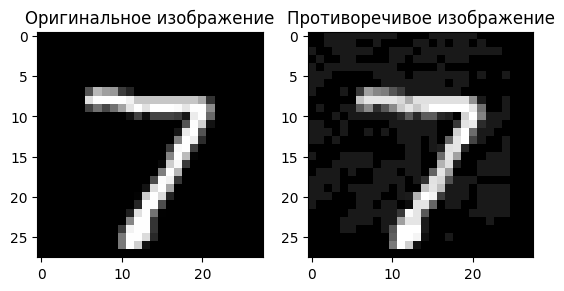

In [ ]:
# Отображение оригинального и противоречивого изображений
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(test_images[0], cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение")
plt.imshow(adversarial_example.reshape(28, 28), cmap="gray")
plt.show()

# *Шаг 4: Оценка модели на противоречивых примерах*

In [ ]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm  # Для прогресса

# Функция для генерации противоречивых примеров с прогрессом
def generate_adversarial_dataset(model, images, labels, epsilon, num_samples=100):
    adversarial_images = []

    # Ограничим выборку до num_samples для ускорения
    if num_samples > len(images):
        num_samples = len(images)

    print(f"Генерация {num_samples} противоречивых примеров с FGSM атакой...")

    for i in tqdm(range(num_samples)):
        adv_image = generate_adversarial_example(model, images[i], labels[i], epsilon)
        adversarial_images.append(adv_image.reshape(28, 28))

    adversarial_images = np.array(adversarial_images)
    return adversarial_images

# Установка параметров
epsilon = 0.1  # Величина шума
num_samples = 100  # Выбираем количество примеров для генерации

# Генерация противоречивых примеров
adversarial_images = generate_adversarial_dataset(model, test_images, test_labels, epsilon, num_samples)

# Преобразование противоречивых изображений для использования в модели
adversarial_images_reshaped = adversarial_images.reshape(num_samples, 28, 28, 1)

# Оценка модели на чистых данных
test_loss, test_acc = model.evaluate(test_images[:num_samples], test_labels[:num_samples])
print(f'Точность на чистых изображениях: {test_acc}')

# Оценка модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images_reshaped, test_labels[:num_samples])

# Вывод результатов
print(f'Точность на чистых изображениях: {test_acc}')
print(f'Точность на противоречивых примерах: {adversarial_acc}')

Генерация 100 противоречивых примеров с FGSM атакой...


100%|██████████| 100/100 [00:02<00:00, 42.12it/s]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9908 - loss: 0.0419 
Точность на чистых изображениях: 0.9900000095367432
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8436 - loss: 0.5151 
Точность на чистых изображениях: 0.9900000095367432
Точность на противоречивых примерах: 0.8199999928474426
